# Libraries

In [2]:
import numpy as np
import torch
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch import optim
import numpy as np
from tqdm.auto import tqdm

# Generator

In [3]:
def generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True)
    )

In [4]:
class Generator(nn.Module):
    def __init__(self, noise_dim, hidden_dim, image_dim):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            generator_block(noise_dim, hidden_dim),
            generator_block(hidden_dim, 2*hidden_dim),
            generator_block(2*hidden_dim, 4*hidden_dim),
            generator_block(4*hidden_dim, 8*hidden_dim),
            nn.Linear(8*hidden_dim, image_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Discriminator

In [5]:
def discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(negative_slope=0.2)
    )

In [6]:
class Discriminator(nn.Module):
    def __init__(self, image_dim, hidden_dim):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            discriminator_block(image_dim, 4*hidden_dim),
            discriminator_block(4*hidden_dim, 2*hidden_dim),
            discriminator_block(2*hidden_dim, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.model(x)

# All together

### Calculate Discriminator and Generator Losses

In [7]:
def get_loss_dis(model_gen, model_dis,
                 real_image,
                 num_images, noise_dim,
                 criterion,
                 device):

    # some fake images will generate by Generator
    x_hat = model_gen(get_noise(num_images, noise_dim, device=device)).detach()

    # Discriminator determine how fake images are Fake (With Fake images)
    y_hat_fake = model_dis(x_hat)
    loss_fake = criterion(y_hat_fake, torch.zeros_like(y_hat_fake))

    # Discriminator determine how real images are Realistic (With Real images)
    y_hat_real = model_dis(torch.flatten(real_image, start_dim=1))
    loss_real = criterion(y_hat_real, torch.ones_like(y_hat_real))

    # Weighted Average
    loss_dis = (real_image.shape[0] * loss_real + num_images * loss_fake) / (real_image.shape[0] + num_images)

    return loss_dis

In [8]:
def get_loss_gen(model_gen, model_dis,
                 num_images, noise_dim,
                 criterion,
                 device):

    # some fake images will generate by Generator
    x_hat = model_gen(get_noise(num_images, noise_dim, device=device))

    # Discriminator determine how fake images are Fake (With Fake images)
    y_hat_fake = model_dis(x_hat)
    loss_gen = criterion(y_hat_fake, torch.ones_like(y_hat_fake))

    return loss_gen

### Helper functions

In [9]:
def save_model(model_gen, model_dis, epoch, root):
    filename = root + f'\model_epoch_{epoch}.pt'
    torch.save({'epoch' : epoch,
                'model_dis_state_dict' : model_dis.state_dict(),
                'model_gen_state_dict' : model_gen.state_dict()},
               filename)

In [10]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

### Hyper parameters

In [11]:
# hyper parameter
hidden_dim = 128
noise_dim=64
image_dim=28*28
batch_size=128
lr=0.00001
epochs=200
num_images = 128
disp_freq=100


root_ds='D:\GitHub\gan-lab\Dataset'
root_models = "D:\GitHub\gan-lab\Models"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Data

In [12]:
dataloader = DataLoader(
    MNIST(root_ds, download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

In [13]:
def get_noise(n_samples, noise_dim, device='cpu'):
    return torch.randn(n_samples, noise_dim, device=device)

### Get instance from Dis/Gen classes & criterion & Optimizers

In [14]:
# get instance from models
model_dis = Discriminator(image_dim, hidden_dim).to(device)
model_gen = Generator(noise_dim, hidden_dim, image_dim).to(device)

# Loss function
criterion=nn.BCEWithLogitsLoss()

# Optimizers
optim_dis = optim.Adam(model_dis.parameters(), lr=lr)
optim_gen = optim.Adam(model_gen.parameters(), lr=lr)

In [15]:
for x, y in dataloader:
    x=x
    y=y
    break

In [16]:
image = get_noise(num_images, noise_dim, device=device)
gen_out = model_gen(image)
dis_out = model_dis(gen_out)
print(image.shape)
print(gen_out.shape)
print(dis_out.shape)

torch.Size([128, 64])
torch.Size([128, 784])
torch.Size([128, 1])


### Train GAN

############################################################
###### Epoch 1 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Loss Dis: 0.30	Loss Gen: 1.84


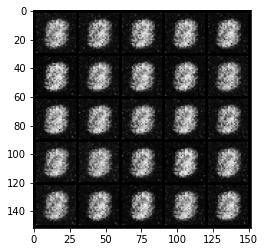

############################################################
###### Epoch 2 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Loss Dis: 0.18	Loss Gen: 2.02


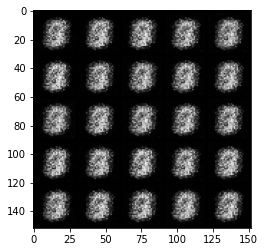

############################################################
###### Epoch 3 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Loss Dis: 0.14	Loss Gen: 2.31


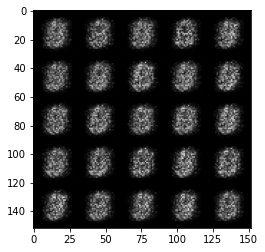

############################################################
###### Epoch 4 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Loss Dis: 0.21	Loss Gen: 1.76


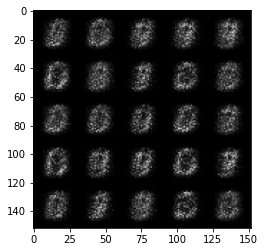

############################################################
###### Epoch 5 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Loss Dis: 0.23	Loss Gen: 1.63


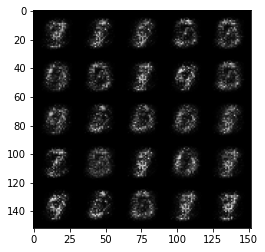

############################################################
###### Epoch 6 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Loss Dis: 0.16	Loss Gen: 1.98


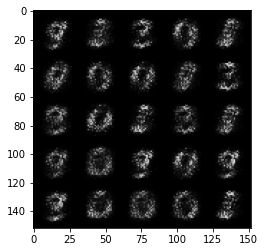

############################################################
###### Epoch 7 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Loss Dis: 0.12	Loss Gen: 2.34


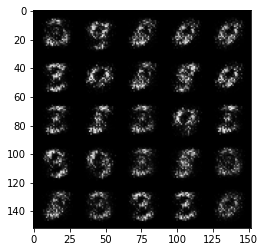

############################################################
###### Epoch 8 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [46]:
loss_gen_min = np.Inf

for epoch in range(1,epochs+1):
    print(60 * "#")
    print(6 * "#" + " Epoch " + str(epoch) + " " + 45 * "#")
    print(60 * "#")

    # Set mode on "train mode"
    model_gen.train()
    model_dis.train()

    for real_image, _ in tqdm(dataloader):
        # GPU (model and data)
        real_image=real_image.to(device)

        # Discriminator Learning
        optim_dis.zero_grad()
        loss_dis = get_loss_dis(model_gen, model_dis, real_image, num_images, noise_dim, criterion, device)
        loss_dis.backward()
        optim_dis.step()

        # Generator Learning
        optim_gen.zero_grad()
        loss_gen = get_loss_gen(model_gen, model_dis, num_images, noise_dim, criterion, device)
        loss_gen.backward()
        optim_gen.step()

    #save_model(model_gen, model_dis, epoch, root_models)
    print("Loss Dis: {:.2f}\tLoss Gen: {:.2f}".format(loss_dis,loss_gen))
    model_gen.eval()
    fake_images = model_gen(get_noise(25, noise_dim, device=device)).view(-1,28,28)
    show_tensor_images(fake_images)

# END